In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr,chi2_contingency
%matplotlib inline

In [2]:
df=pd.read_csv("data/bank-full.csv",sep=";")
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


# Funcion: get_features_cat_regression
Esta función recibe como argumentos un dataframe, el nombre de una de las columnas del mismo (argumento 'target_col'), que debería ser el target de un hipotético modelo de regresión, es decir debe ser una variable numérica continua o discreta pero con alta cardinalidad y una variable float "pvalue" cuyo valor por defecto será 0.05.

La función debe devolver una lista con las columnas categóricas del dataframe cuyo test de relación con la columna designada por 'target_col' supere en confianza estadística el test de relación que sea necesario hacer (es decir la función debe poder escoger cuál de los dos test que hemos aprendido tiene que hacer).

La función debe hacer todas las comprobaciones necesarias para no dar error como consecuecia de los valores de entrada. Es decir hará un check de los valores asignados a los argumentos de entrada y si estos no son adecuados debe retornar None y printar por pantalla la razón de este comportamiento. Ojo entre las comprobaciones debe estar que "target_col" hace referencia a una variable numérica continua del dataframe.

In [29]:
def get_features_cat_regression(df,target_col,umbral_card=0.5,pvalue=0.05):
    """
    Descripción:
        La función identifica las variables categóricas de un dataframe que se consideran features de una variable target en función de su correlación.

    Argumentos:
        df (Pandas Dataframe) : El DataFrame sobre el que trabajar.
        target_col: varible objetivo (numérica continua o discreta) del df.
        pvalue: valor que restado a 1 nos indica el intervalo de confianza para la identificación de features (cómo correlan con la vasriable target)
        umbral_card: umbral mínimo de alta cardinalidad, es decir, valor a partir del cual consideramos una alta cardinalidad 

    Returns:
        cat_features: lista de las variables categóricas que han sido identificadas como features.
    """
    # Comprobación valores de entrada:
    if target_col not in df.columns:
        print(f"Error: la columna {target_col} no existe.")
        return None
    if not np.issubdtype(df[target_col].dtype, np.number):
        print(f"Error: La columna '{target_col}' no es una variable numérica continua.")
        return None
    if (df[target_col].nunique()/(len(df[target_col])*100))<umbral_card:
        print(f"Error: la cardinalidad de la columna {target_col} es inferior a {umbral_card}.")
        return None
    if pvalue is not None and not (0 <= pvalue <= 1):
        print("Error: pvalue debe ser None o un número entre 0 y 1.")
        return None

    # Creación del listado de features categóricas:
    categorical_cols = df.select_dtypes(include='object').columns.tolist()
    cat_features = []
    for col in categorical_cols: # Calcular la correlación y p-values para cada columna numérica con 'target_col'
        contingency_table = pd.crosstab(df[col], df[target_col])
        chi2, p_value, dof, expected= chi2_contingency(contingency_table)
        #print(f"{col} --> {p_value}")
        if p_value < pvalue:
            cat_features.append(col)
    return(cat_features)

In [53]:
get_features_cat_regression(df,"duration",umbral_card=0,pvalue=0.03)

['job', 'marital', 'contact', 'month', 'poutcome', 'y']

# Funcion: plot_features_cat_regression
Esta función recibe un dataframe, una argumento "target_col" con valor por defecto "", una lista de strings ("columns") cuyo valor por defecto es la lista vacía, un argumento ("pvalue") con valor 0.05 por defecto y un argumento "with_individual_plot" a False.

Si la lista no está vacía, la función pintará los histogramas agrupados de la variable "target_col" para cada uno de los valores de las variables categóricas incluidas en columns que cumplan que su test de relación con "target_col" es significatio para el nivel 1-pvalue de significación estadística. La función devolverá los valores de "columns" que cumplan con las condiciones anteriores.

Si la lista está vacía, entonces la función igualará "columns" a las variables numéricas del dataframe y se comportará como se describe en el párrafo anterior.

De igual manera que en la función descrita anteriormente deberá hacer un check de los valores de entrada y comportarse como se describe en el último párrafo de la función get_features_cat_regression.

In [68]:
def plot_features_cat_regression(df,target_col="",columns=[],umbral_card=0.5,pvalue=0.05,with_indivudual_plot=False,umbral_corr=0):
    """
    Descripción:
        La función dibuja los histogramas de la variable objetivo para cada una de las features.

    Argumentos:
        df: El DataFrame sobre el que trabajar.
        target_col: varible objetivo (numérica continua o discreta) del df.
        columns: listado de variables categóricas. Por defecto está vacío.
        pvalue: valor que restado a 1 nos indica el intervalo de confianza para la identificación de features (cómo correlan con la variable target). Por defecto 0.05.
        with_individual_plot: argumento para dibujar el histograma individual o agrupado (por defecto).

    Returns:
        figure: histogramas
    """
    # Comprobación de los valores de entrada:
    if target_col not in df.columns:
        print(f"Error: la columna {target_col} no existe.")
        return None
    if not np.issubdtype(df[target_col].dtype, np.number):
        print(f"Error: La columna '{target_col}' no es una variable numérica continua.")
        return None
    if (df[target_col].nunique()/(len(df[target_col])*100))<umbral_card:
        print(f"Error: la cardinalidad de la columna {target_col} es inferior a {umbral_card}.")
        return None
    if pvalue is not None and not (0 <= pvalue <= 1):
        print("Error: pvalue debe ser None o un número entre 0 y 1.")
        return None
    
    
    # Revisión del listado columns y creación de los gráficos.
    # Si columns está vacía:
    if columns==[]:
        columns = df.select_dtypes(include=['number']).columns.tolist()
        num_features = []  # Filtra las columnas basadas en la correlación y el valor p
        for col in columns:
            if col != target_col:
                correlation, p_value = pearsonr(df[col], df[target_col])
                if abs(correlation) > umbral_corr and (pvalue is None or p_value < pvalue):
                    num_features.append(col)
        num_cols = len(num_features)
        fig, axes = plt.subplots(nrows=1, ncols=num_cols, figsize=(15, 5))
        for i, col in enumerate(num_features):
            ax = axes[i]
            sns.histplot(data=df, x=target_col, y=col, ax=ax, bins=20, color='skyblue', edgecolor='black')
            ax.set_title(f'{col} vs {target_col}')
            ax.set_xlabel(target_col)
            ax.set_ylabel('Frequency')
        plt.tight_layout()
        plt.show()   
    # Si columns contiene info:
    else:
        columns_in_df=[]
        for col in columns:
            if col in df.columns:
                columns_in_df.append(col)
        if columns_in_df==[]:
            print(f"Error: las columnas no coinciden con las del df.")
            return None                
        categorical_cols = df.select_dtypes(include='object').columns.tolist()
        cat_features = []
        for col in categorical_cols: 
            contingency_table = pd.crosstab(df[col], df[target_col])
            chi2, p_value, dof, expected= chi2_contingency(contingency_table)
            if p_value < pvalue:
                cat_features.append(col)
        if not cat_features:
            print("No se encontraron características categóricas significativas.")
            return None
        for col in columns_in_df:
            if col in cat_features:
                plt.figure(figsize=(10, 6))
                sns.histplot(data=df, x=target_col, hue=col, palette='Set1', multiple='stack')
                plt.title(f'Histograma de {col} en relación con {target_col}')
                plt.xlabel(target_col)
                plt.ylabel('Frecuencia')
                plt.legend(title=col)
                plt.show()
        


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


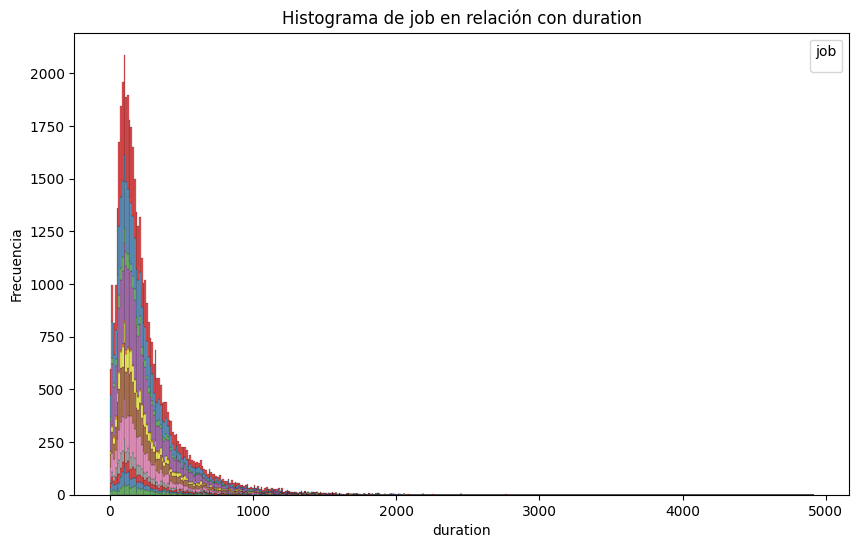

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


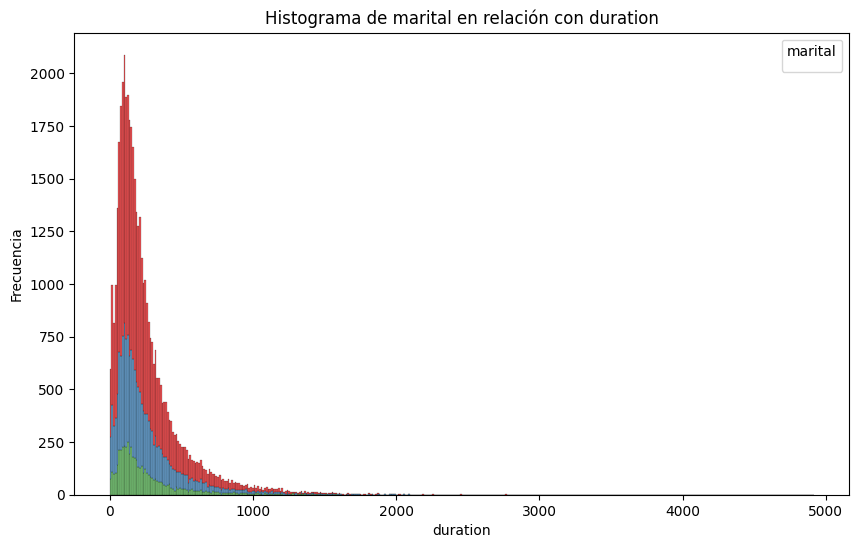

In [69]:
plot_features_cat_regression(df,"duration",columns=["ojo","job","marital"],umbral_card=0)